In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
import csv
import datetime
from collections import Counter

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 1000)  # or 1000
pd.set_option('display.max_colwidth', None) 
pd.options.plotting.backend = "plotly"

In [2]:
directory = "API-logs/"

### Code Carbon logs

In [79]:
carbondf = pd.DataFrame(columns = ['date', 'timestamp', 'RAM energy', 'GPU energy', 'GPU power', 'CPU energy', 'Energy consumed'])

In [80]:
ins=[]
with open(directory+'carbon.log' , 'r') as f:
    lines = f.readlines() # readlines creates a list of the lines
    for line in lines:
        if 'Sep' in line:
            ins.append(lines.index(line))
len(lines)

143138

In [81]:
alldates, sep22, sep23, sep24, sep25, sep26= [], [], [], [], [], []
sep22 = lines[ins[0]:ins[1]]
print(len(sep22))
alldates.append(sep22)
sep23 = lines[ins[1]:ins[2]]
print(len(sep23))
alldates.append(sep23)
sep24 = lines[ins[2]:ins[3]]
alldates.append(sep24)
print(len(sep24))
sep25 = lines[ins[3]:ins[4]]
alldates.append(sep25)
print(len(sep25))
sep26 = lines[ins[4]:len(lines)]
alldates.append(sep26)
print(len(sep26))

13408
36577
36573
36577
20003


In [82]:
count=0
for day in alldates: 
    date= day[0].replace('\n','')
    print(date)
    print(len(day))
    for i in range(1, len(day), 4):
        for line in day[i:i + 4]:
            try:
                time = line.split('@')[1].split(']')[0].strip()
            except:
                continue
            if 'RAM :' in line: 
                ram_nrj = line.split('Energy consumed for RAM :')[1].split('RAM')[0].replace('kWh.','')
            elif 'GPUs'in line:
                gpu_nrj = line.split('Energy consumed for all GPUs :')[1].split('All GPUs')[0].replace('kWh.','')
                gpu_power = line.split('All GPUs Power : ')[1].replace('W','').strip()
            elif 'CPUs' in line:
                cpu_nrj= line.split('Energy consumed for all CPUs :')[1].split('All CPUs')[0].replace('kWh.','')
            elif ' electricity used since the begining.' in line:
                total_nrj = line.split(' electricity used since the begining.')[0].split(']')[1].replace(' of','').replace('kWh','')
        carbondf.loc[count] = [date, time, ram_nrj, gpu_nrj, gpu_power, cpu_nrj, total_nrj]
        count+=1

22/Sep/2022
13408
23/Sep/2022
36577
24/Sep/2022
36573
25/Sep/2022
36577
26/Sep/2022
20003


In [87]:
carbondf["Energy consumed"] = pd.to_numeric(carbondf["Energy consumed"])
carbondf["GPU power"] = pd.to_numeric(carbondf["GPU power"])

In [88]:
carbondf.shape

(35784, 7)

In [89]:
carbondf.date.value_counts()

23/Sep/2022    9144
25/Sep/2022    9144
24/Sep/2022    9143
26/Sep/2022    5001
22/Sep/2022    3352
Name: date, dtype: int64

In [90]:
#carbondf = carbondf.sort_values('Energy consumed')
#carbondf = carbondf.reset_index(drop=True)

In [91]:
carbondf.head()

,date,timestamp,RAM energy,GPU energy,GPU power,CPU energy,Energy consumed
0,22/Sep/2022,15:12:02,0.001395,0.006703,2412.392,0.000125,0.008222
1,22/Sep/2022,15:12:12,0.002708,0.013103,2446.520,0.000243,0.016054
2,22/Sep/2022,15:12:22,0.004022,0.021320,3138.044,0.000361,0.025703
3,22/Sep/2022,15:12:32,0.005333,0.024947,1389.091,0.000478,0.030758
4,22/Sep/2022,15:12:42,0.006658,0.028631,1395.522,0.000597,0.035886


In [92]:
carbondf['time'] = carbondf['date'] + ' ' + carbondf['timestamp'].astype(str)

In [93]:
carbondf['time'] = pd.to_datetime(carbondf['time'] , format= "%d/%b/%Y %H:%M:%S")

In [94]:
carbondf.tail()

,date,timestamp,RAM energy,GPU energy,GPU power,CPU energy,Energy consumed,time
35779,26/Sep/2022,13:07:07,44.674263,149.981416,1321.076,3.991420,198.645777,2022-09-26 13:07:07
35780,26/Sep/2022,13:07:08,44.674263,149.985048,1379.301,3.991539,198.650850,2022-09-26 13:07:08
35781,26/Sep/2022,13:07:08,44.674263,149.985048,1379.301,3.991539,198.650850,2022-09-26 13:07:08
35782,26/Sep/2022,13:07:17,44.675578,149.991459,2447.144,3.991539,198.650850,2022-09-26 13:07:17
35783,26/Sep/2022,13:07:18,44.675578,149.991459,2447.144,3.991657,198.658694,2022-09-26 13:07:18


In [124]:
carbondf['date']= carbondf.index

## Energy consumption by 10 min

In [142]:
carbonhourdf = carbondf.groupby(pd.Grouper(key = 'time', freq='10min')).last()
carbonhourdf.tail()

,date,timestamp,RAM energy,GPU energy,GPU power,CPU energy,Energy consumed
time,,,,,,,
2022-09-26 12:20:00,35544,12:29:57,44.379839,148.984825,3601.582,3.965095,197.319061
2022-09-26 12:30:00,35608,12:39:58,44.459049,149.254942,1900.962,3.972296,197.686286
2022-09-26 12:40:00,35671,12:49:57,44.538203,149.543014,2431.645,3.979260,198.052738
2022-09-26 12:50:00,35735,12:59:58,44.617507,149.795291,2402.331,3.986463,198.399261
2022-09-26 13:00:00,35783,13:07:18,44.675578,149.991459,2447.144,3.991657,198.658694


In [143]:
carbonhourdf['Energy by interval'] = carbonhourdf["Energy consumed"].diff()

In [144]:
carbonhourdf = carbonhourdf.iloc[7:-1 , :]
carbonhourdf.shape

(556, 8)

In [145]:
carbonhourdf.head()

,date,timestamp,RAM energy,GPU energy,GPU power,CPU energy,Energy consumed,Energy by interval
time,,,,,,,,
2022-09-22 16:20:00,493,16:29:52,0.616152,2.986218,1763.207,0.055257,3.651571,0.460664
2022-09-22 16:30:00,556,16:39:52,0.695054,3.367438,1412.097,0.062223,4.123394,0.471823
2022-09-22 16:40:00,620,16:49:53,0.773883,3.757831,2599.632,0.069425,4.592904,0.469510
2022-09-22 16:50:00,683,16:59:52,0.852737,4.133765,1476.121,0.076390,5.061579,0.468675
2022-09-22 17:00:00,747,17:09:53,0.931576,4.517707,2447.751,0.083592,5.525039,0.463460


In [146]:
carbonhourdf.tail()

,date,timestamp,RAM energy,GPU energy,GPU power,CPU energy,Energy consumed,Energy by interval
time,,,,,,,,
2022-09-26 12:10:00,35481,12:19:58,44.300638,148.691290,2490.415,3.958129,196.950057,0.365278
2022-09-26 12:20:00,35544,12:29:57,44.379839,148.984825,3601.582,3.965095,197.319061,0.369004
2022-09-26 12:30:00,35608,12:39:58,44.459049,149.254942,1900.962,3.972296,197.686286,0.367225
2022-09-26 12:40:00,35671,12:49:57,44.538203,149.543014,2431.645,3.979260,198.052738,0.366452
2022-09-26 12:50:00,35735,12:59:58,44.617507,149.795291,2402.331,3.986463,198.399261,0.346523


In [147]:
carbonhourdf['date']= carbonhourdf.index

### Server logs

In [148]:
with open(directory+'time-server.log','r') as f:
    lines = f.readlines() # readlines creates a list of the lines
len(lines)

54481

In [149]:
requestdf = pd.DataFrame(columns = ['date', 'requests'])

In [150]:
import re
count=0
for line in lines:
    if "POST /generate HTTP/1.1" in line:
        time = line.split('[')[1].split(']')[0]
        code = line.split("POST /generate HTTP/1.1")[1]
        code= re.sub("[^0-9]", "", code)
        code= code.replace('0400','400')
        requestdf.loc[count] = [time, code]
        count+=1

In [151]:
requestdf['date'] = pd.to_datetime(requestdf['date'] , format= "%d/%b/%Y %H:%M:%S")

In [152]:
requestdf['requests'] = pd.to_numeric(requestdf['requests'])

In [153]:
requestdf.requests.value_counts()

200    53332
400     1149
Name: requests, dtype: int64

200 = OK we answered

400 = used bad request

503 = refused because no more room in the queue

### Average number of requests per hour

In [154]:
requesthourdf = requestdf.groupby(pd.Grouper(key = 'date', freq='60min')).count()
requesthourdf['requests'].describe()

count      95.000000
mean      573.484211
std       369.459348
min       112.000000
25%       297.000000
50%       472.000000
75%       698.000000
max      1609.000000
Name: requests, dtype: float64

### Number of requests per 10 minutes

In [155]:
requesthourdf = requestdf.groupby(pd.Grouper(key = 'date', freq='10min')).count()
requesthourdf = requesthourdf.iloc[7:-2 , :]
requesthourdf.tail()

,requests
date,
2022-09-26 12:10:00,129
2022-09-26 12:20:00,133
2022-09-26 12:30:00,137
2022-09-26 12:40:00,139
2022-09-26 12:50:00,75


In [156]:
requesthourdf.head()
#2022-09-22 16:20:00

,requests
date,
2022-09-22 16:20:00,237
2022-09-22 16:30:00,243
2022-09-22 16:40:00,213
2022-09-22 16:50:00,227
2022-09-22 17:00:00,208


In [157]:
requesthourdf.shape

(556, 1)

### Merging the carbon and request DFs

In [158]:
alllogdf = pd.concat([carbonhourdf,requesthourdf], axis=1)
alllogdf['date']= alllogdf.index
alllogdf.shape

(556, 9)

Total time for logs:

In [159]:
alllogdf_diff = alllogdf.iloc[[0, -1]]
alllogdf_diff['date'].iloc[1] -  alllogdf_diff['date'].iloc[0]

Timedelta('3 days 20:30:00')

In [160]:
alllogdf.tail()

,date,timestamp,RAM energy,GPU energy,GPU power,CPU energy,Energy consumed,Energy by interval,requests
2022-09-26 12:10:00,2022-09-26 12:10:00,12:19:58,44.300638,148.691290,2490.415,3.958129,196.950057,0.365278,129
2022-09-26 12:20:00,2022-09-26 12:20:00,12:29:57,44.379839,148.984825,3601.582,3.965095,197.319061,0.369004,133
2022-09-26 12:30:00,2022-09-26 12:30:00,12:39:58,44.459049,149.254942,1900.962,3.972296,197.686286,0.367225,137
2022-09-26 12:40:00,2022-09-26 12:40:00,12:49:57,44.538203,149.543014,2431.645,3.979260,198.052738,0.366452,139
2022-09-26 12:50:00,2022-09-26 12:50:00,12:59:58,44.617507,149.795291,2402.331,3.986463,198.399261,0.346523,75


### Tons of carbon

In [161]:
((198.399261 * 394.0) /1e6)

0.078169308834

### Plotting raw values

In [163]:
alllogdf["GPU power"].describe()

count     556.000000
mean     1708.257097
std       554.411036
min      1296.427000
25%      1310.888500
50%      1332.485000
75%      2399.248250
max      3719.218000
Name: GPU power, dtype: float64

In [162]:
fig1= alllogdf.plot(x="date", y=["GPU power"], kind="line")
fig1.update_layout(
    xaxis_title= "Date",
    yaxis_title="GPU Power Used (W)",
)

In [122]:
fig= alllogdf.plot(kind="scatter", x="requests", y="Energy by interval")
fig.update_layout(
    xaxis_title= "Number of requests received in a 10-minute interval",
    yaxis_title="Energy consumption (kWh)",
)

### Trying to fit quadratic curve

In [38]:
x= alllogdf["requests"]
y= alllogdf["Energy by interval"]

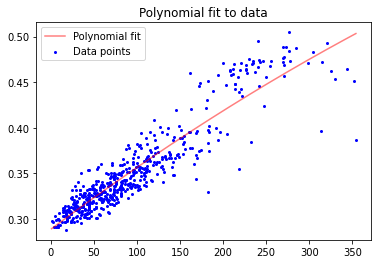

In [166]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 

a, b, c = np.polyfit(x, y, 2)

fit_equation = lambda x: a * x ** 2 + b * x + c

def plot_fit(X, Y, f):
    X_fit = np.linspace(min(X), max(X), 1000)
    Y_fit = f(X_fit)

    fig, ax1 = plt.subplots()
    ax1.plot(X_fit, Y_fit, color='r', alpha=0.5, label='Polynomial fit')
    ax1.scatter(X, Y, s=4, color='b', label='Data points')
    ax1.set_title('Polynomial fit to data')
    ax1.legend()
    plt.show()
    
plot_fit(x, y, fit_equation)


#### Calculating intercept:

In [167]:
fit_equation(0)

0.28842679888794365